## Assignment 1a: Machine Learning Methods

### \<Sakshi Sinha> \<a1898508>

#### How can we use data analytics to predict energy usage for this house?

![download.jfif](attachment:download.jfif)

#### Follow detail instructions in the assignment specification and use these heading for implementation and discussion

### 1. Read the dataset

In [1]:
#Importing modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score



#load the datasets
df = pd.read_csv("/content/energydata_complete.csv")


### 2. Analyse and visualise the data

In [2]:
# Exploring data to get some initial idea about dataset
print(f"Display the first few rows of the DataFrame \n {df.head()}")
print(f"Display DataFrame information \n {df.info()}")
print(f"Display summary statisticsd \n {df.describe()}")


Display the first few rows of the DataFrame 
                date  Appliances  lights     T1       RH_1    T2       RH_2  \
0  11/01/2016 17:00          60      30  19.89  47.596667  19.2  44.790000   
1  11/01/2016 17:10          60      30  19.89  46.693333  19.2  44.722500   
2  11/01/2016 17:20          50      30  19.89  46.300000  19.2  44.626667   
3  11/01/2016 17:30          50      40  19.89  46.066667  19.2  44.590000   
4  11/01/2016 17:40          60      40  19.89  46.333333  19.2  44.530000   

      T3       RH_3         T4  ...         T9   RH_9  T_out  Press_mm_hg  \
0  19.79  44.730000  19.000000  ...  17.033333  45.53   6.60        733.5   
1  19.79  44.790000  19.000000  ...  17.066667  45.56   6.48        733.6   
2  19.79  44.933333  18.926667  ...  17.000000  45.50   6.37        733.7   
3  19.79  45.000000  18.890000  ...  17.000000  45.40   6.25        733.8   
4  19.79  45.000000  18.890000  ...  17.000000  45.40   6.13        733.9   

   RH_out  Windspeed  

The dataset consists of 19,735 observations and does not contain any missing values. Below are some key observations from the initial exploration:

1. The dataset has 29 columns, each representing different features. It covers variety of features, such as environmental measurements inside the house (T1 to T9 for temperature, RH_1 to RH_9 for humidity), energy use (Appliances, lights), and weather conditions (T_out, Press_mm_hg, RH_out, Windspeed, Visibility, Tdewpoint).

2. The date column is of type object, which likely needs to be converted to datetime for any time series analysis.

3. The target variable for our regression model is Appliances, which represents the energy use in a household in Wh.



In [3]:
correlation_matrix = df.corr()


<ipython-input-3-68bbfff3c4eb>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


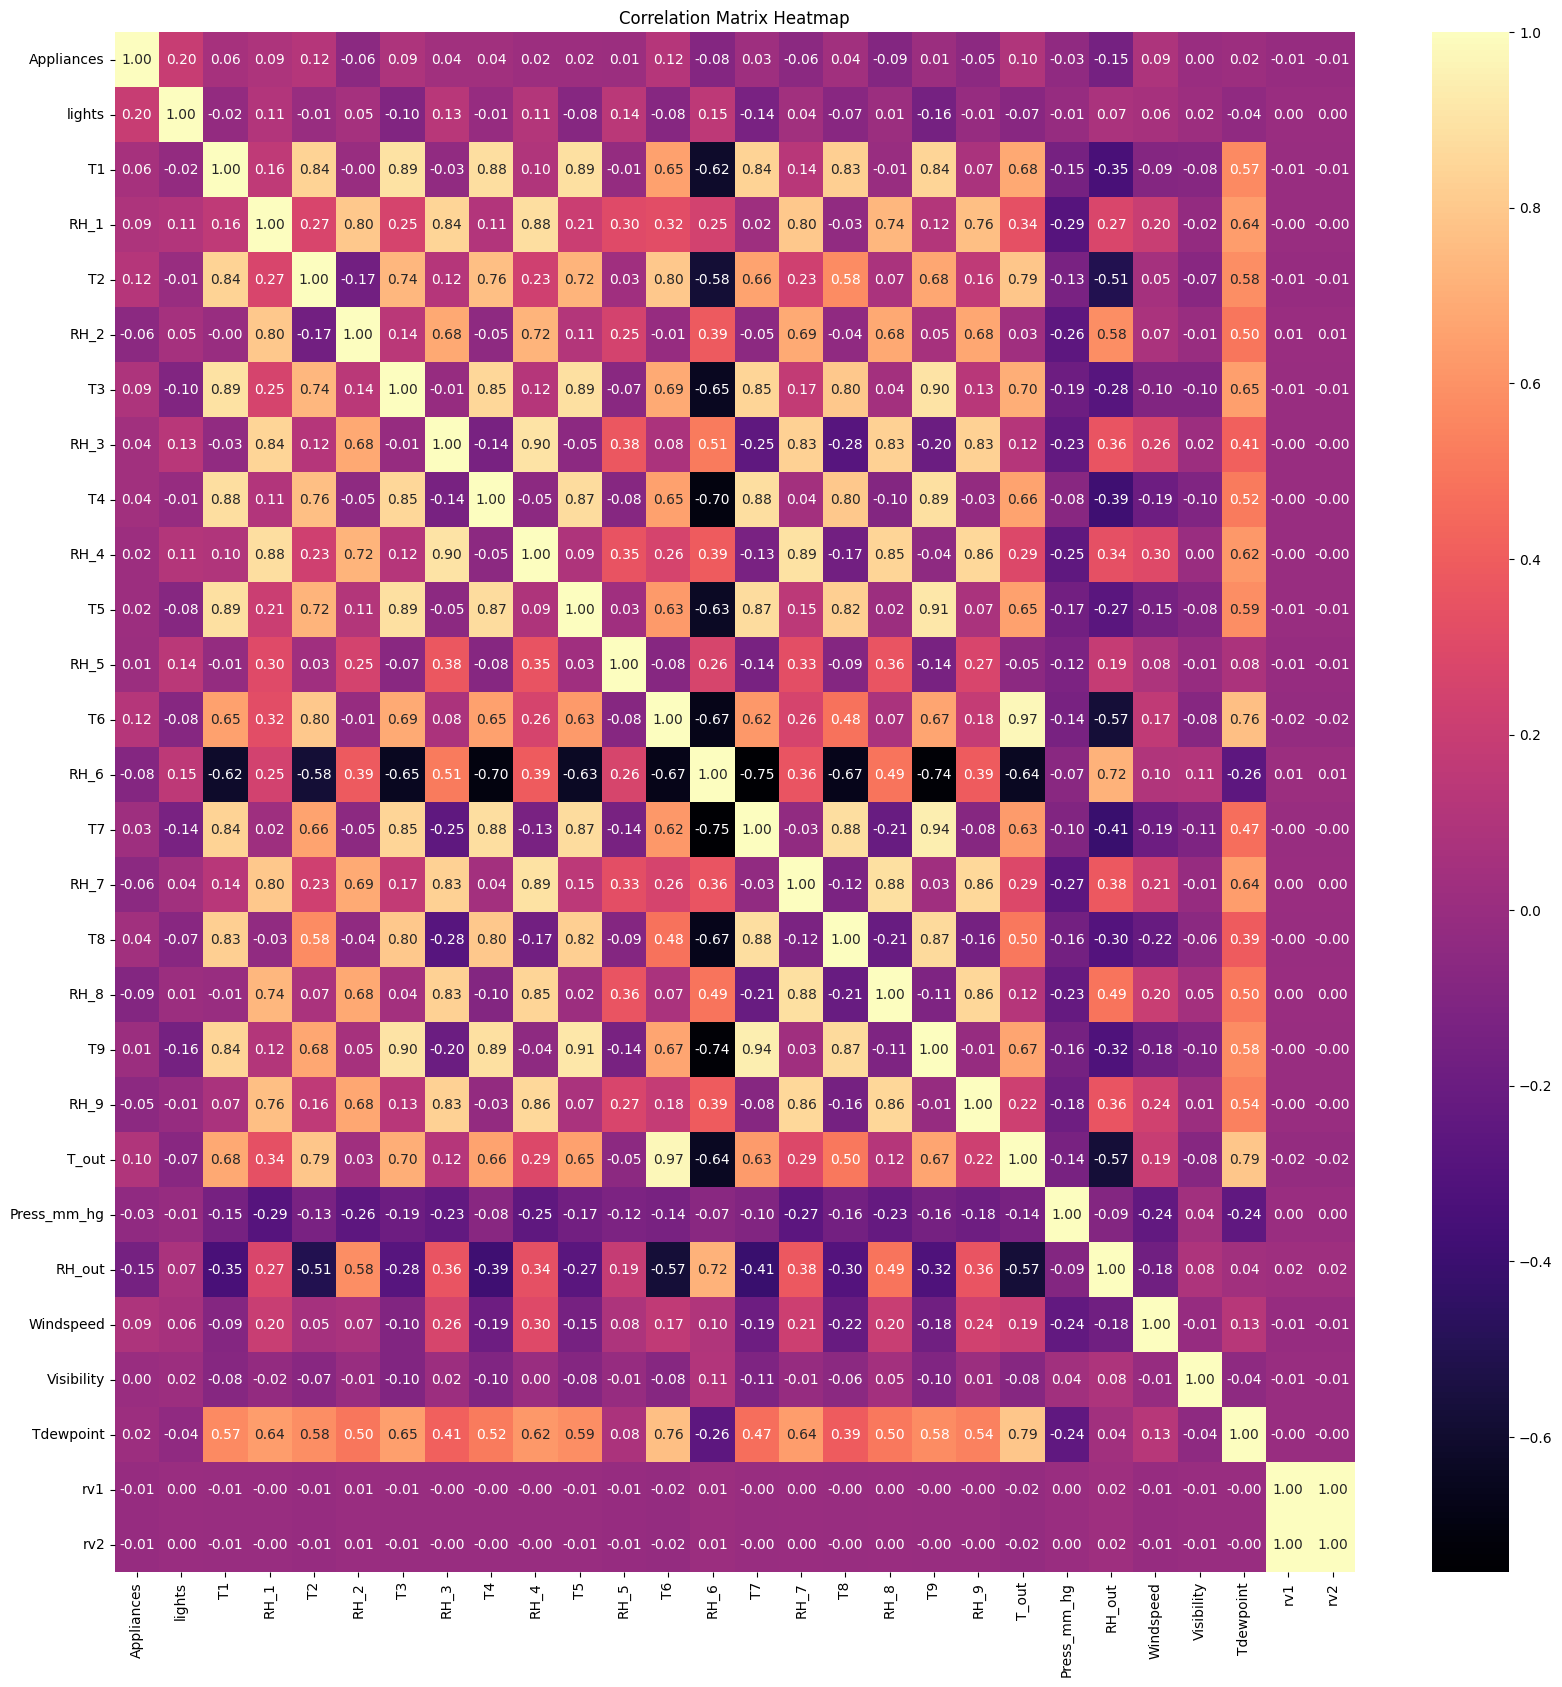

In [4]:
# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='magma', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()


From the heat map I can see there is strong correlation(whether positive or negative) between temperature(T1 to T9) and humidity(RH_1 to RH_9) levels both within the household and with outdoor conditions(T_out, RH_out, Windspeed, etc.).

To better understand the correlation of target variable 'Appliance' with other features, I have plotted below bar graph.

<ipython-input-5-1e7bde7daa93>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


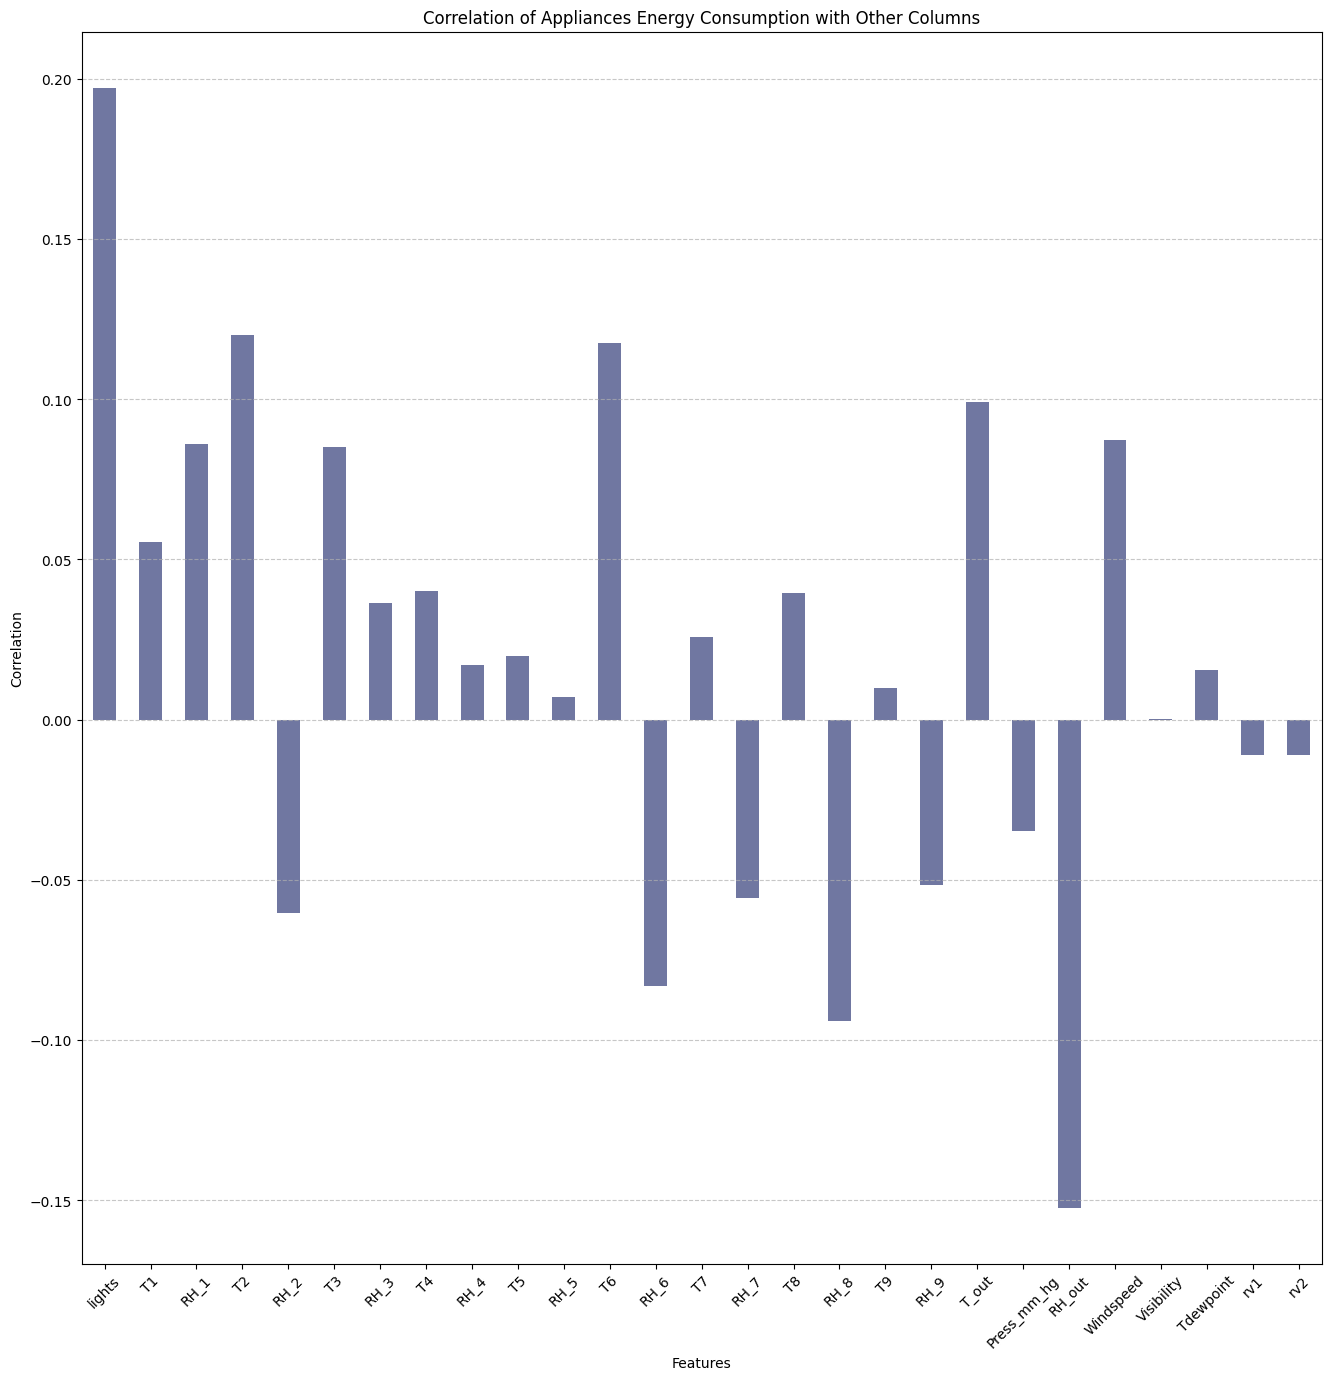

In [5]:
# Compute the correlation matrix
correlation_matrix = df.corr()

# Select the correlation of 'Appliances' with other columns
appliance_correlation = correlation_matrix['Appliances'].drop('Appliances')

# Plot the correlation as a bar chart
plt.figure(figsize=(16, 16))
appliance_correlation.plot(kind='bar', color='#7077A1')
plt.title('Correlation of Appliances Energy Consumption with Other Columns')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

From the above graph I can easily see the positive/negative correlation between appliance and rest of the features present in the dataset. The correlation values are not extremely high for any single feature, suggesting that the energy use of appliances is likely influenced by a mix of factors rather than a single dominant predictor. T_out (temperature outside) and Tdewpoint also show a moderate correlation with Appliances, underscoring the potential impact of external weather conditions on energy use.

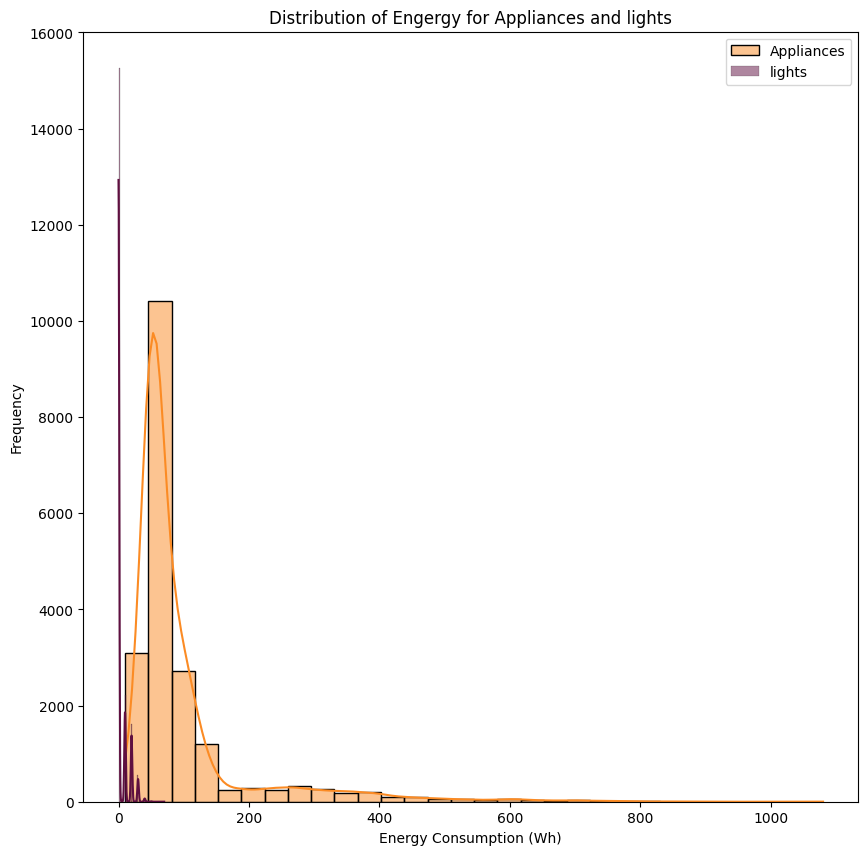

In [6]:
# Distribution of Energy for Appliances and lights
plt.figure(figsize=(10, 10))
sns.histplot(df['Appliances'], bins=30, kde=True, color='#FB8B24', label='Appliances')
sns.histplot(df['lights'], bins=30, kde=True, color='#5F0F40', label='lights')
plt.title('Distribution of Engergy for Appliances and lights')
plt.xlabel('Energy Consumption (Wh)')
plt.ylabel('Frequency')
plt.legend()
plt.show()


From the above graph I can observe that both appliances and light graph are tilted towards the right indicating lower consumption values are more common than higher ones. Most of the time, energy consumption for appliances and lights is minimal, with peaks occurring at lower energy levels.

Appliances have a broader range of energy consumption than lights, indicating higher variety in their usage patterns.

This graphic aids in understanding the dataset's typical energy usage trends as well as identifying any odd consumption levels that may need more investigation.


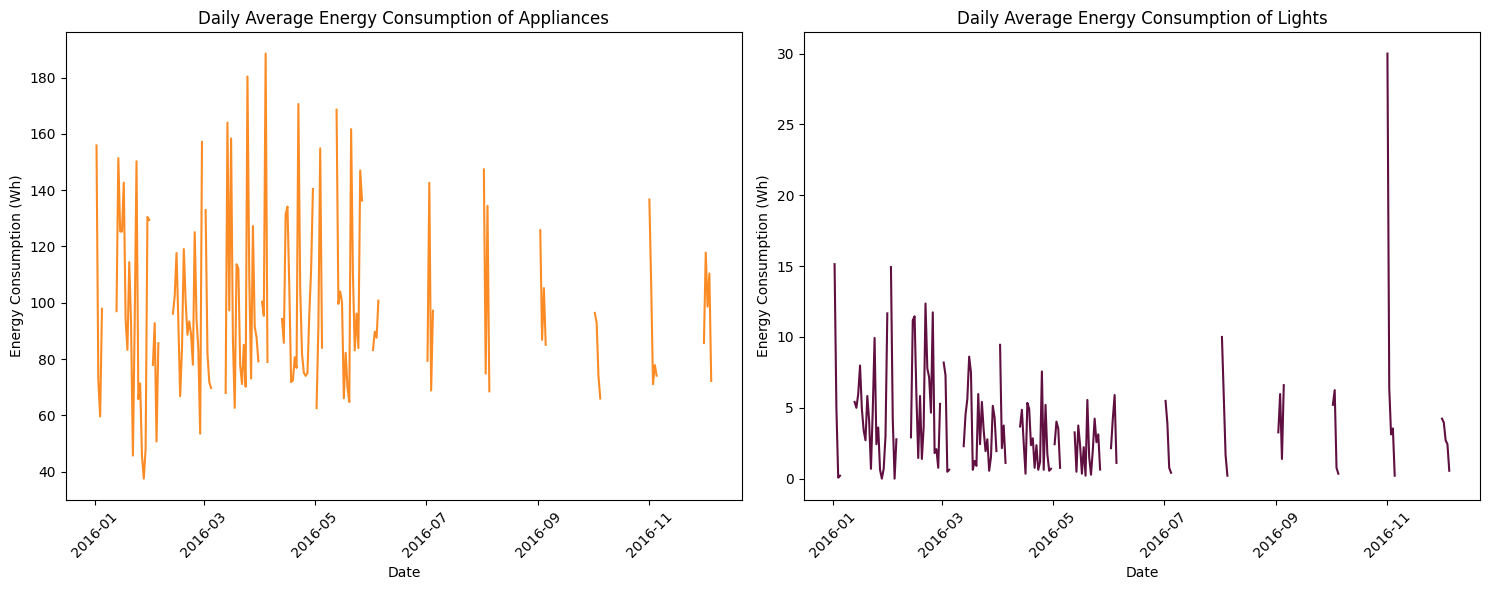

In [7]:
# Convert 'date' column to datetime format and setting it as the index of the dataframe
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Resample data to daily frequency and calculating the mean for each day
daily_data = df.resample('D').mean()

# Plotting the graph
plt.figure(figsize=(15, 6))

# Appliances energy consumption
plt.subplot(1, 2, 1)
plt.plot(daily_data.index, daily_data['Appliances'], color='#FB8B24')
plt.title('Daily Average Energy Consumption of Appliances')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (Wh)')
plt.xticks(rotation=45)

# Lights energy consumption
plt.subplot(1, 2, 2)
plt.plot(daily_data.index, daily_data['lights'], color='#5F0F40')
plt.title('Daily Average Energy Consumption of Lights')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (Wh)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



I made below observations from these graphs:

1. Appliances: I can notice fluctuations in energy consumption of appliances over time, which showcases influcence by factors like outdoor temperature, no. of people living in the hous, etc.

2. Light: Light enery use also varies, likely corresponding to changes in daylight hours, occupancy, etc.

These findings give me a good idea about what affects energy use every day and throughout the year.

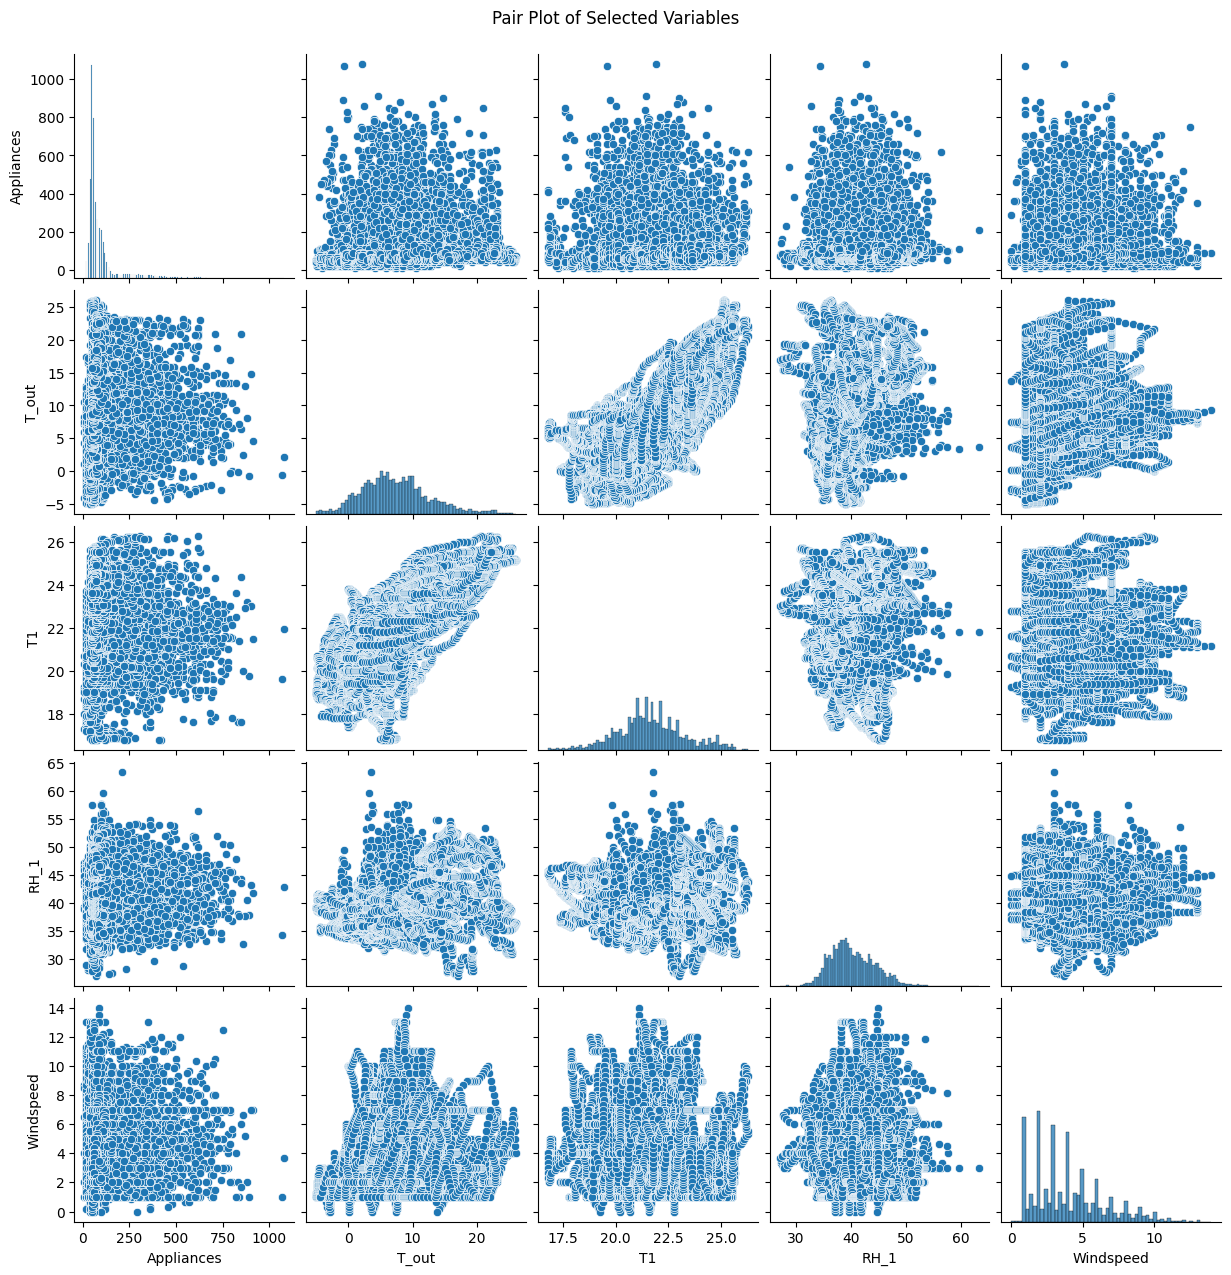

In [8]:
# Selecting a subset of variables for the pair plot
selected_columns = ['Appliances', 'T_out', 'T1', 'RH_1', 'Windspeed']
subset_data = df[selected_columns]

# Generating the pair plot
sns.pairplot(subset_data)
plt.suptitle('Pair Plot of Selected Variables', y=1.02)
plt.show()


The pair plot provides me a thorough look at how different variables are related and their distributions:

Diagonal Plots: Above plots depict the distribution of each variable using histograms for Appliances, T_out, T1, RH_1, and Windspeed. It shows us the typical values and ranges for each factor.

Off-Diagonal Plots:  In each plot, I explore how two features are connected. For instance, the scatter plot of Appliances vs. T_out helps us see how energy usage changes with outdoor temperature. Other plots dive into relationships like appliances with indoor temperature (T1), humidity (RH_1), and windspeed.

These visuals help us spot trends, like potential straight or curved connections, and groups within the data. They also highlight how much each variable changes, giving clues about what might have a bigger impact on energy usage.

Based on all the data analysis, I have decided to concentrate on the following aspects:

1. Indoor environmental features: This includes monitoring temperature and humidity levels across different rooms (T1, RH_1, T2, RH_2, etc.).

2. Lighting usage: The amount of energy used by lighting fixtures (lights) is directly linked to overall energy consumption.

3. Outdoor Weather features: Take into account external temperature (T_out), dew point temperature (Tdewpoint), and possibly Windspeed and RH_out (external humidity), as these factors can impact heating and cooling requirements.



### 3. Pre-process the data

In [28]:
# Reload the dataset
file_path = '/content/energydata_complete.csv'
data = pd.read_csv(file_path)

# Convert 'date' column to datetime format and extract features
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['day_of_week'] = data['date'].dt.dayofweek  # Monday=0, Sunday=6
data['hour'] = data['date'].dt.hour

# Prepare features and target variables including the new time-based features
X = data.drop(['date', 'Appliances'], axis=1)
y = data['Appliances']

# Splitting the data into training and testing sets, with 15,788 samples for training and 3,947 samples for testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the features including the new time-based features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.shape, X_test_scaled.shape, y_train.shape, y_test.shape


((15788, 30), (3947, 30), (15788,), (3947,))

After updating the dataset with new features derived from the date column, such as month, day_of_week, and hour, it is now prepared for modeling. With 15,788 observations in the training set and 3,947 in the testing set, I have a total of 30 features to train my model on.

### 4. Implement, train and test prediction models

**Models**

Given the dataset and the job of predicting future energy usage, I'm going to use the following models to try and find the best one for this dataset:

Linear Regression: It's like a starting point for building a basic model. Linear regression is commonly used for forecasting and understanding relationships between variables. I have tried this previous in concept of AI course and wanted to apply it here to check how approproate will it be for my dataset.

Gradient Boosting Regressor and Random Forests: both Random Forests and Gradient Boosting Regressor are powerful algorithms for regression tasks, each with its strengths and weaknesses. RandomForest is simpler to use and less prone to overfitting, while Gradient Boosting Regressor tends to offer higher predictive accuracy but requires more tuning. This was also used in the original paper and gave pretty decent results.

XGBoost: XGBoost can give us super accurate predictions by learning from past mistakes. It can handle all sorts of data, including categorical variables if we have any.

**Testing Parameters**

In order to compare the performance of each of the regression
models, below testing parameters are used:

* RMSE (Root Mean Squared Error): This metric gives an idea of the magnitude of errors between the predictions and actual values. A smaller RMSE indicates better performance.

* R2 (Coefficient of Determination): This gives us an idea of how closely our model's predictions match the real data. If the R2 value is close to 1, it means our model explains most of the variability in the target variable.

In [39]:
# Initializing all models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=500,random_state=42),
    "Gradient Boosting Regressor": GradientBoostingRegressor(random_state=42, learning_rate = 0.61, n_estimators=500),
    "XGBoost Regressor": XGBRegressor(random_state=42, reg_lambda=1, reg_alpha=3.80),
}

# Initialize results dictionary
model_results = {'Model': [], 'RMSE_Train': [], 'RMSE_Test': [], 'R2_Train': [], 'R2_Test': []}

# For loop used for fitting models and evaluating it against train/test sets
for name, model in models.items():
    # Fitting the model
    model.fit(X_train_scaled, y_train)

    # Making predictions on the train/test set
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)

    # Calculating RMSE and R2 for train/test sets
    rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
    rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)

    # Storing the results
    model_results['Model'].append(name)
    model_results['RMSE_Train'].append(rmse_train)
    model_results['RMSE_Test'].append(rmse_test)
    model_results['R2_Train'].append(r2_train)
    model_results['R2_Test'].append(r2_test)

# Converting result to dataframe and displaying it
results = pd.DataFrame(model_results)
results


,Model,RMSE_Train,RMSE_Test,R2_Train,R2_Test
0,Linear Regression,94.059962,91.076692,0.168210,0.171091
1,Random Forest Regressor,25.858128,67.048435,0.937137,0.550769
2,Gradient Boosting Regressor,33.199673,74.390529,0.896373,0.446997
3,XGBoost Regressor,40.080786,68.299112,0.848965,0.533854


### 5. Compare the results from all candidate models, choose the best model, justify your choice and discuss the results

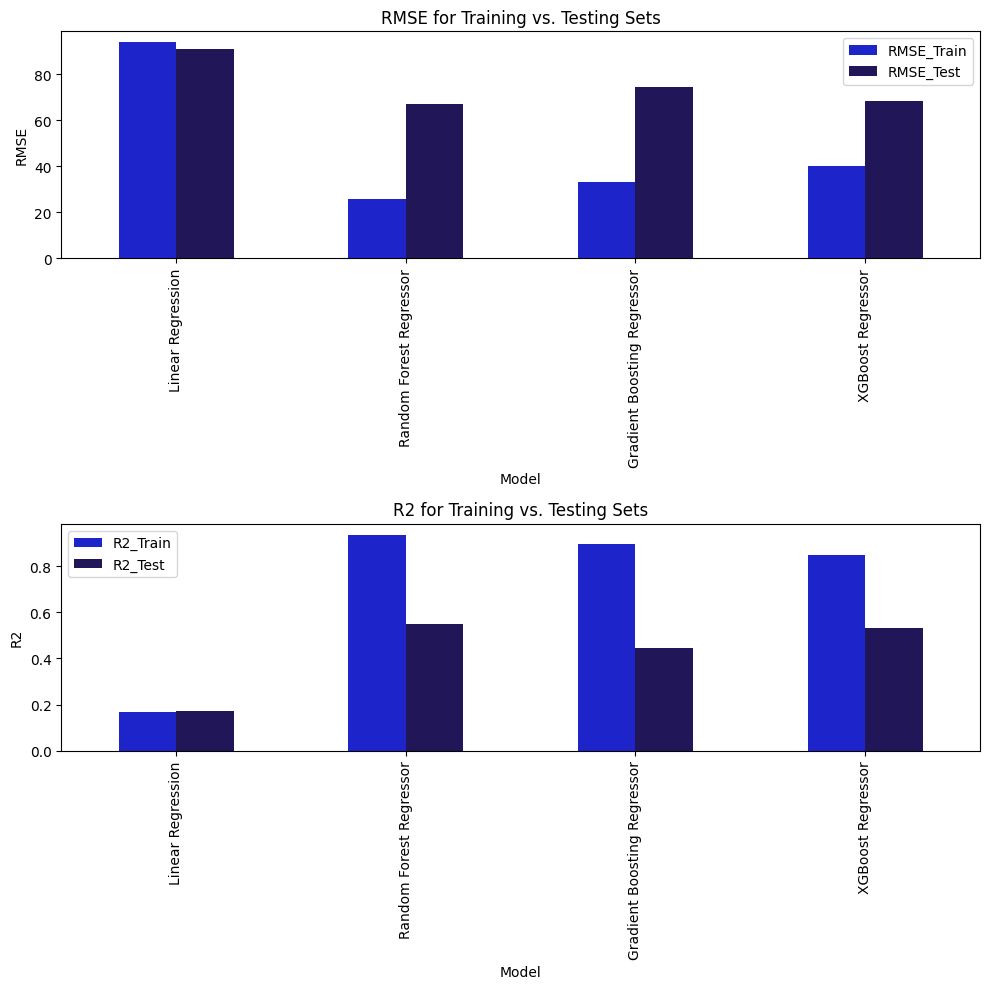

In [41]:
# Plotting
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# RMSE Plot
results.plot(kind='bar', x='Model', y=['RMSE_Train', 'RMSE_Test'], ax=ax[0], color=['#1D24CA', '#201658'])
ax[0].set_title('RMSE for Training vs. Testing Sets')
ax[0].set_ylabel('RMSE')

# R2 Plot
results.plot(kind='bar', x='Model', y=['R2_Train', 'R2_Test'], ax=ax[1], color=['#1D24CA', '#201658'])
ax[1].set_title('R2 for Training vs. Testing Sets')
ax[1].set_ylabel('R2')

plt.tight_layout()
plt.show()


**Analysis:**

The above graph shows the evaluation findings for the potential models. Linear regression has weak predictive power, with large root mean squared error (RMSE) values and low R2 scores on both the training and testing sets. While Gradient Boosting and XGBoost regressors perform well, they still fall behind the Random Forest Regressor in terms of RMSE and R2 scores.

The Random Forest Regressor has the lowest RMSE on the testing set (67.048435) and the highest R2 score (0.550769), indicating better prediction accuracy and model fit compared to the other models. Furthermore, its performance measurements show a decent balance across the training and testing sets, implying resilience and generalizability.



**Conculsion**

Given the metrics and performance across both the training and testing datasets, the Random Forest Regressor emerges as the top model due to below reasons

1. The Random Forest Regressor has the lowest RMSE (Root Mean Squared Error) on the test set (67.048435), indicating higher predictive accuracy than other models. A lower RMSE indicates that the model's predictions are more similar to the actual data.

2. The Random Forest Regressor has the best R2 score on the test set (0.550769), suggesting that it explains a greater fraction of the variance in the target variable than other models. A higher R2 score indicates improved model fit and predictive capability.

3. While Gradient Boosting and XGBoost regressors perform well, the Random Forest Regressor is more consistent between training and testing results. This consistency implies resilience and generalization capacity, which are required for good predictive modeling.


### 6. Reflect on what you have learned by completing this assignment and how to improve the models

In [44]:
# Dropping the lights feature from X parameter
X = data.drop(['date', 'Appliances', 'lights'], axis=1)

# Splitting the data into training and testing sets, with 15,788 samples for training and 3,947 samples for testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling new features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.shape, X_test_scaled.shape, y_train.shape, y_test.shape


((15788, 29), (3947, 29), (15788,), (3947,))

In [45]:
# Initialize the Random Forest Regressor model
model = RandomForestRegressor(n_estimators=500, random_state=42)

# Fit the model
model.fit(X_train_scaled, y_train)

# Make predictions on the training and testing sets
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

# Calculate RMSE and R2 for train and test sets
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

# Store the results
model_results = {
    'Model': 'Random Forest Regressor',
    'RMSE_Train': rmse_train,
    'RMSE_Test': rmse_test,
    'R2_Train': r2_train,
    'R2_Test': r2_test
}

results = pd.DataFrame([model_results])
results

,Model,RMSE_Train,RMSE_Test,R2_Train,R2_Test
0,Random Forest Regressor,24.833454,62.997113,0.94202,0.603418


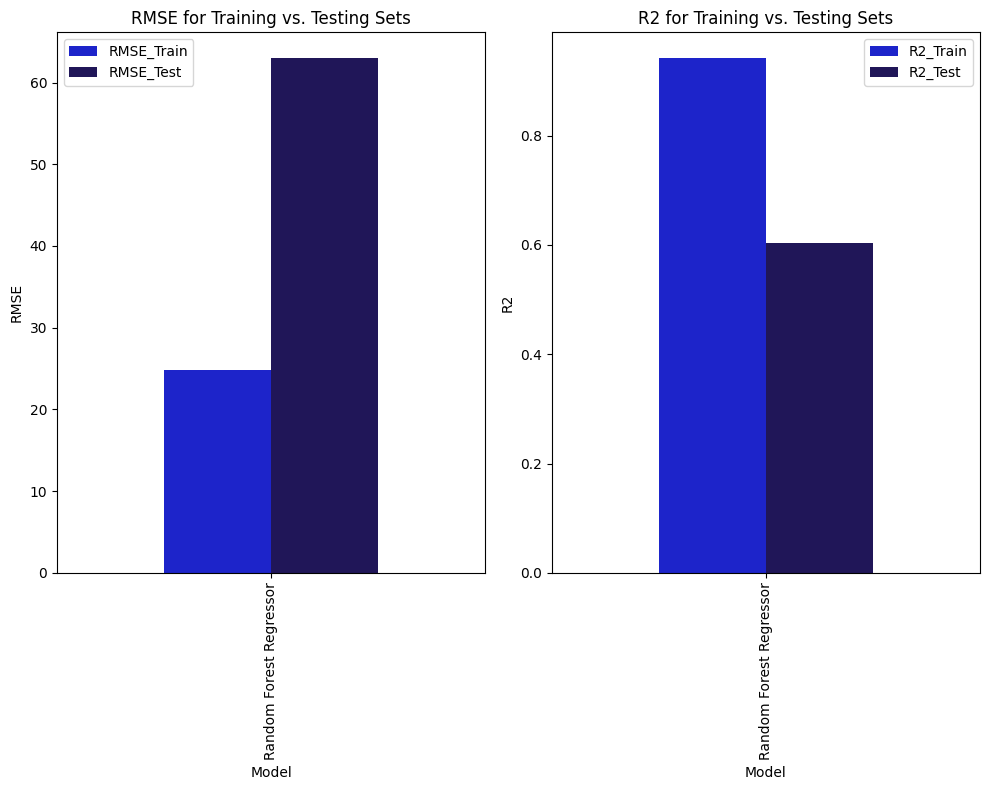

In [52]:
# Plotting
fig, ax = plt.subplots(1, 2, figsize=(10, 8))

# RMSE Plot
results_df.plot(kind='bar', x='Model', y=['RMSE_Train', 'RMSE_Test'], ax=ax[0], color=['#1D24CA', '#201658'])
ax[0].set_title('RMSE for Training vs. Testing Sets')
ax[0].set_ylabel('RMSE')

# R2 Plot
results_df.plot(kind='bar', x='Model', y=['R2_Train', 'R2_Test'], ax=ax[1], color=['#1D24CA', '#201658'])
ax[1].set_title('R2 for Training vs. Testing Sets')
ax[1].set_ylabel('R2')

plt.tight_layout()
plt.show()



#**Ways to improve model performance**

**Feature Selection**

After studying the data heatmap, it is clear that there is a strong correlation between the lights feature and the appliance. As discussed in the lecture, one successful strategy for feature selection is to remove strongly correlated characteristics from the dataset. However, it should be noted that the heatmap only displays linear dependencies and may not capture non-linear relationships. In order to increase the Random Forest model's performance, I eliminated the lights column and ran further experiments. Consequently, the model's performance improved.

A comparison of the old and new Random Forest Regressor models indicates significant performance improvements. The previous model had larger RMSE values for both the training and testing sets, indicating higher prediction errors than the new model. The new Random Forest Regressor has lower RMSE values for both the training and testing sets, indicating improved prediction accuracy. Furthermore, the new model had higher R2 scores for both the training and testing sets, indicating that the model suited the data better than the old model. Overall, the new Random Forest Regressor has improved performance metrics, demonstrating that it is effective at predicting energy appliance use.

While investigating other correlations, I discovered somewhat strong relationships between the appliance and RH_out properties. Surprisingly, removing the RH_out feature dropped R2 scores while increasing RMSE values for the random forest regressor. This pattern was consistent with the initial research findings, emphasizing the nonlinear link between external humidity and the appliance column. As a result, it appears that the RH_out feature provides useful information for estimating energy appliance usage.

**Training model on larger dataset**

As mentioned in the paper, the dataset is limited to data from a single household, limiting the models study scope. Incorporating data from numerous households allows for a more comprehensive understanding of energy usage trends, resulting in more robust and generalizable models. Furthermore, extending the duration of the data collection allows to record seasonal fluctuations in energy demand, which improves the model's prediction capabilities.

**Ensemble Methods**

Combine multiple models to improve prediction accuracy. Techniques such as bagging, boosting, and stacking can help reduce overfitting and capture different aspects of the data.

**Cross-Validation**

Use cross-validation techniques to evaluate the model's performance more reliably and prevent overfitting. Techniques like k-fold cross-validation can provide a better estimate of how the model will perform on unseen data.


**Better sensor placement**

Improving sensor placement, particularly the distance between the house and the weather station, as well as indoor sensor placement in the proper area, to more effectively and accurately estimate energy. Furthermore, investing in more accurate sensors could improve the precision of energy consumption projections. These changes in the positioning of sensors and quality can have a major impact on the accuracy and performance of models trained on the dataset.

#**Learning Experience**

This assignment helped me grasp the correlation between different variables, specifically the relationship between dependent and independent variables. Data mining taught me about numerous graphical representations that can effectively explain these correlations and assist correct data analysis to produce reliable prediction results. The emphasis on data analysis and visualization underlined the importance of this step in the data preprocessing phase, where factors like as data balance, missing values, and feature selection all have a significant impact on model performance.

I gained a better understanding of the importance of data in model training, as well as how diverse and precise data can improve model generalization power. Overall, this experience was enriching, and I loved the assignment's emphasis on developing a greater grasp of the role of data in the modeling process.

### 7. References

Candanedo, L.M., Feldheim, V. and Deramaix, D., 2018. Reconstruction of the indoor temperature dataset of a house using data driven models for performance evaluation. Building and Environment, 138, pp.250-261.

Mining big data(COMP_SCI_7306)

 Concepts in Artificial Intelligence and Machine Learning	(COMP_SCI_7327)